In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # 0 means that at initialisation we are assuming that the value does not affect the output
    self._backward = lambda: None
    # i.e. changing this variable is not changing the loss function L
    self._prev = set(_children) # this is used to maintain what values actually created the output
    self._op = _op # this is used to maintain what operation was used to create the output
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # just to be able to operations like a + 1 on integers etc.
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      # our job from the above written line is to take 'out''s grad and propogate it to 'self''s grad and other nodes grad
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __truediv__(self, other):
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += out.grad * (1 - t**2)
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out  = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)

    self.grad  = 1.0
    for node in reversed(topo):
      node._backward()

In [3]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create and rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
# now we would like to do back propogation i.e. start from the end node and go back and calculate the gradient at all these previous values
# essentially the derivative of L wrt to each of these parameters
# i.e. the derivative of this loss function wrt this loss function wrt to the weights a,b,c,d,e,f

# What is backpropagation?
Backpropogation is the method we use to calculate gradients for each parameter (like weights and biases) in the network. It is basically the chain rule applied over the entire network

How it works?


*   Forward Pass - The network process an input and produces an output. During this pass, it records the operations it performs.
*   Loss Function - The output is compared to the true value using a loss or cost function (for eg. mean squared error). This loss quantifies 'how wrong' the network is.
*   Backward Pass - Using the chain rule, we calculate how much each parameter contributed to the error by propogating the loss backward through the network. This tells us the gradient (i.e. how much a small change in a parameter would change the loss).





In [5]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

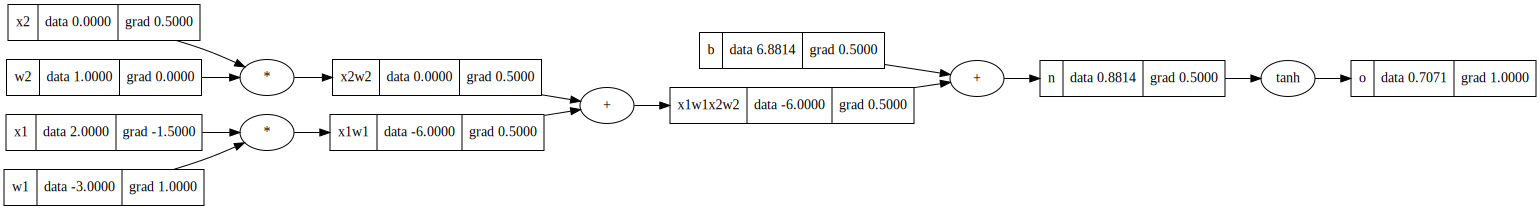

In [6]:
draw_dot(o)

In [7]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# --------
x = 2*n
o = (x.exp() - 1) / (x.exp() + 1); o.label = 'o'
# --------
o.backward()

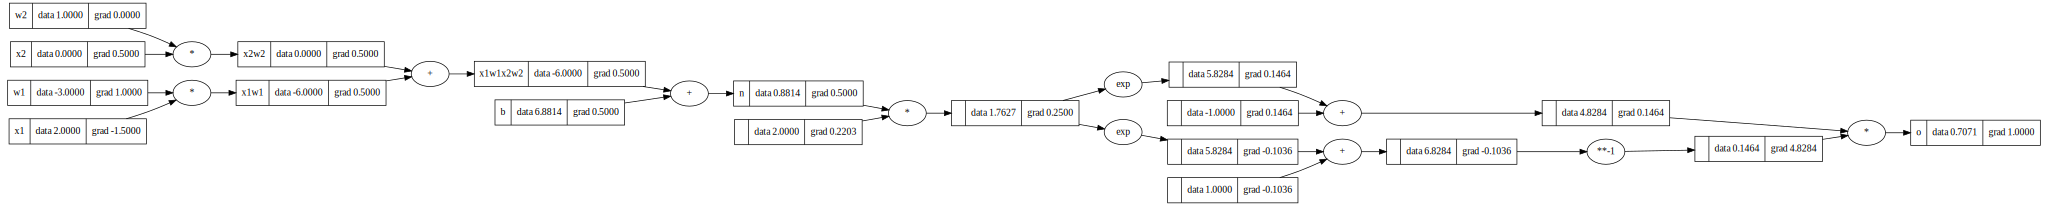

In [8]:
draw_dot(o)

In [9]:
import torch

In [10]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [11]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [12]:
import random

In [13]:
class Neuron:
  # the constructor will take the number of inputs that come to a neuron
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    # and now we need to pass it through some non-linearity
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  # nout - is basically the number of neurons you want in this layer i.e. the number of outputs
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs;

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  # in the Layer class we took nout which was the number of outputs of a single layer, here 'nouts' would be a list of number of outputs for each layer
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0] # here we have a 3-d input
n = MLP(3, [4, 4, 1]) # this basically signifies that we have 3 inputs in 2 layers of 4 and 1 output
n(x) # output of the forward pass of the Multi Layer Perceptron that we just built

Value(data=0.7207733123753186)

In [14]:
n.parameters()

[Value(data=0.26354777778031124),
 Value(data=0.07637574936977631),
 Value(data=-0.24527378508047848),
 Value(data=-0.09389725801413995),
 Value(data=-0.17789097601956172),
 Value(data=0.3779495870375966),
 Value(data=0.36960933849763),
 Value(data=0.4644480075735562),
 Value(data=-0.26002765245015547),
 Value(data=0.9210266875942619),
 Value(data=-0.08636160072667742),
 Value(data=-0.889027475329472),
 Value(data=0.5690698211230873),
 Value(data=0.1719135344984779),
 Value(data=0.9951642895722908),
 Value(data=0.10036094385455874),
 Value(data=0.5941234703684539),
 Value(data=-0.33264032934961363),
 Value(data=0.2642481064329416),
 Value(data=-0.5654924164308062),
 Value(data=0.005235536937780116),
 Value(data=-0.8235185753371501),
 Value(data=0.13432407765850507),
 Value(data=-0.22961516779019475),
 Value(data=-0.017068375006253245),
 Value(data=0.7472306706884042),
 Value(data=-0.7556870960818662),
 Value(data=0.3213007930893399),
 Value(data=-0.9967969417440787),
 Value(data=0.6803

In [34]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [35]:
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0)) # mean squared loss and now our task is to tune the neural net weights in such a way as to minimise the loss

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 3.4650450047935114e-07
1 3.4650398447645194e-07
2 3.4650346847513876e-07
3 3.4650295247540423e-07
4 3.465024364772402e-07
5 3.4650192048079455e-07
6 3.4650140448564745e-07
7 3.4650088849232353e-07
8 3.465003725005355e-07
9 3.4649985651015084e-07
10 3.4649934052145717e-07
11 3.464988245344891e-07
12 3.4649830854894457e-07
13 3.464977925648381e-07
14 3.464972765824428e-07
15 3.4649676060148555e-07
16 3.4649624462221195e-07
17 3.464957286445603e-07
18 3.464952126685207e-07
19 3.4649469669382704e-07


In [32]:
ypred

[Value(data=0.999967272462043),
 Value(data=-0.9995273199814839),
 Value(data=-0.9996507436279852),
 Value(data=0.9999938492387243)]